In [1]:
%matplotlib inline

import cv2
import numpy as np
from scipy.signal import savgol_filter
from scipy.ndimage import rotate
import PIL
import matplotlib.pyplot as plt
import math
from scipy.fft import fft, fftfreq, fftshift
from libmtf import read_image, Point, ROI, get_roi, get_hamming, get_deriv1, get_centroid, get_polyfit, get_fir2fix, project2

In [2]:
def plot_images(image_left, image_right):
    plt.subplot(1, 2, 1)
    plt.title("hori line")
    plt.imshow(image_left, "gray")
    # plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.title("vert line")
    plt.imshow(image_right, cmap="gray")
    # plt.colorbar()

def step0_load_image(filename):
    image = read_image(filename)
    return image

def step1_get_roimage(image, topleft, bottomright, rotation):
    roi_image, roi = get_roi(image, topleft, bottomright)
    roi_image = rotate(roi_image, rotation)
    return roi_image, roi

def get_derivative(roi_image):
    deriv = roi_image
    return roi_image

def plot_derivatives(deriv):
    plt.subplot(1, 2, 1)
    plt.title("LSF for all rows")
    for i in range(deriv.shape[0]):
        plt.plot(deriv[i, :])
    
    plt.subplot(1, 2, 2)
    plt.title("LSF for first row")
    plt.plot(deriv[0,:])      

def get_fit(curve):
    x = np.arange(len(curve))
    y = curve
    fit = get_polyfit(x, y, 1)
    return fit
    
def step4_get_centroid_and_fit(deriv, hamming_win):
    centroid = get_centroid(deriv * hamming_win) - 0.5
    fit = get_fit(centroid)
    return centroid, fit

def plot_centroid(image, centroid, fit):
    plt.title("LSF and fittings")
    plt.imshow(image)
    plt.plot(centroid, np.arange(len(centroid)), 'r')

    x = np.arange(len(centroid))
    y = centroid

    plt.plot(np.polyval(fit, x), x, "y")

def plot_lsf(lsf_curve, centroid, fit, roi_image_limited):
    plt.subplot(1, 2, 1)
    plt.title("LSF after Hamming window")
    plt.imshow(lsf_curve)
    plt.plot(centroid, np.arange(len(centroid)), 'r')

    x = np.arange(len(centroid))
    y = centroid
    plt.plot(np.polyval(fit, x), x, "y")

    plt.subplot(1, 2, 2)
    plt.title("LSF limted")
    plt.imshow(roi_image_limited)

def step5_fit_central(fit, centroid, deriv_v, win1_v):
    centroid_place = np.polyval(fit, np.arange(len(centroid)))
    hamming_width = deriv_v.shape[1]

    win2 = [get_hamming(hamming_width, centroid_place[i]) for i in range(len(centroid_place))]
    win2 = np.array(win2)
    deriv_hamming_windowed = deriv_v*win2

    centroid, fit = step4_get_centroid_and_fit(deriv_hamming_windowed, win1_v)

    slout_ = -fit[0]
    slout = 180*math.atan(slout_)/math.pi

    # Evaluate equation at the middle line as edge location
    midloc = np.polyval(fit, deriv_v.shape[0]/2)

    # Limit number of lines to integer (npix*line slope as per ISO 12233
    nlin = deriv_v.shape[0]
    a = math.floor(nlin*abs(slout))
    b = abs(slout)
    nlin1 = round(a/b)

    roi_image_limited = deriv_hamming_windowed[:nlin1, :]

    # plot_lsf(deriv_hamming_windowed, centroid, fit, roi_image_limited)

    vslope = -fit[0]
    slope_deg = slout
    delimage = 1

    # correct sampling interval for sampling normal to edge
    delfac = math.cos(math.atan(vslope))

    # input pixel sampling normal to edge
    del1n = delfac
    nbin = 4
    # super-sampling interval normal to edge
    del2 = del1n/nbin

    nn = math.ceil(deriv_hamming_windowed.shape[1]*nbin)
    nn2 = math.floor(nn/2) + 1

    # dcorr corrects SFR for response of FIR filter
    dcorr = get_fir2fix(nn2, 3)

    freqlim = 1
    if nbin == 1:
        freqlim = 2
        
    nn2out = round(nn2*freqlim/2)

    # half-sampling frequency
    nfreq = nn/(2*delimage*nn)    

    return roi_image_limited, nbin, nn2, del2

def step6_super_sample(roi_image_limited, fit, nbin):
    esf = project2(roi_image_limited, fit, nbin)
    l = len(esf)
    esf[l-1] = esf[l-2]
    return esf

def step7_get_lsf(esf):
    lsf1 = esf
    return lsf1

def step8_apply_win_to_lsf(lsf1_v):
    nn = len(lsf1_v)
    mm = np.argmax(lsf1_v)

    win3_v = get_hamming(nn, mm)
    win3_v = np.array(win3_v)
    lsf1_v = np.array(lsf1_v)
    lsf_v = lsf1_v * win3_v

    return lsf_v, win3_v

def step9_get_mtf(lsf, nn2, del2):
    temp = abs(fft(lsf))
    mtf = temp[0:nn2] / temp[0]
    # Compute frequency values

    # print("del2", del2, "nn", nn)
    nn = len(lsf)
    freq = [i / (del2*nn) for i in range(nn)]
    freq = np.array(freq)
    mtf = np.array(mtf)

    nn_2_out = 70
    nn2out=nn_2_out # for smartmtf
    efl = 60
    px = 3.45
    px=2.74

    lppd = px/efl/1000 * 180/3.14159

    freq_data = freq[0:nn2out]/lppd
    mtf_data = mtf[0:nn2out]

    return freq_data, mtf_data

def step10_get_mtf_interp(mtf_array, freq_array, frequency):
    for idx, freq in enumerate(freq_array):
        # print(idx, freq)
        if frequency < freq:
            break

    mtf = (frequency-freq_array[idx-1])/(freq_array[idx]-freq_array[idx-1])*(mtf_array[idx]-mtf_array[idx-1]) + mtf_array[idx-1]
    return frequency, mtf
    
def plot_mtf(freq_data, mtf_data, label, linestyle):
    plt.grid(color='gray', linestyle='--', linewidth=1)
    plt.plot(freq_data, mtf_data, label=label, linestyle=linestyle)
    plt.legend()

In [3]:
def thru_focus(index, freq, files, w, h):
    # step 0: load image
    file_item = files[index]
    image = step0_load_image(file_item["filename"])
    title = file_item["title"]
    
    # step 1: get ROI
    roi_image_h, roi = step1_get_roimage(image, file_item["roi_h_pos"], (file_item["roi_h_pos"][0] + w, file_item["roi_h_pos"][1] + h), 90) #90
    roi_image_v, roi = step1_get_roimage(image, file_item["roi_v_pos"], (file_item["roi_v_pos"][0] + h, file_item["roi_v_pos"][1] + w), 0)
    # plot_images(roi_image_h, roi_image_v)
    
    # step 2: hamming window
    win1_h = get_hamming(roi_image_h.shape[1])
    win1_v = get_hamming(roi_image_v.shape[1])
    
    # step 3: get derivative
    deriv_h = get_derivative(roi_image_h)
    deriv_v = get_derivative(roi_image_v)
    # plot_derivatives(deriv_h)
    # plot_derivatives(deriv_v)
    
    # step 4: apply window and compute centroid
    centroid_h, fit_h = step4_get_centroid_and_fit(deriv_h, win1_h)
    centroid_v, fit_v = step4_get_centroid_and_fit(deriv_v, win1_v)
    # plt.plot(1, 2, 1)
    # plot_centroid(deriv_h, centroid_h, fit_h)
    # plt.plot(1, 2, 2)
    # plot_centroid(deriv_v, centroid_v, fit_v)
    
    # step 5: compute polynomial fit to central locations
    
    roi_image_limited_h, nbin_h, nn2_h, del2_h = step5_fit_central(fit_h, centroid_h, deriv_h, win1_h)
    roi_image_limited_v, nbin_v, nn2_v, del2_v = step5_fit_central(fit_v, centroid_v, deriv_v, win1_v)
    
    # step 6: super-sample
    
    esf_h = step6_super_sample(roi_image_limited_h, fit_h, nbin_h)
    esf_v = step6_super_sample(roi_image_limited_v, fit_v, nbin_v)
    # plt.plot(esf_h)
    # plt.plot(esf_v)
    
     # step 7: compute 1D derivative (LSF)
    
    lsf1_h = step7_get_lsf(esf_h)
    lsf1_v = step7_get_lsf(esf_v)
    # plt.plot(lsf1_h)
    # plt.plot(lsf1_v)
    
    # step 8: apply window to LSF
    
    lsf_h, win3_h = step8_apply_win_to_lsf(lsf1_h)
    lsf_v, win3_v = step8_apply_win_to_lsf(lsf1_v)
    # plt.subplot(1, 2, 1)
    # plt.title("without hamming")
    # plt.plot(lsf_h)
    
    # plt.subplot(1, 2, 2)
    # plt.title("hamming")
    # plt.plot(lsf1_h * win3_h)
    # plt.plot(win3_h*200) 
    
    # step 9: MTF
    freq_data_h, mtf_data_h = step9_get_mtf(lsf_h, nn2_h, del2_h)
    freq_data_v, mtf_data_v = step9_get_mtf(lsf_v, nn2_v, del2_v)
    # plot_mtf(freq_data_h, mtf_data_h, "h", "-")
    # plot_mtf(freq_data_v, mtf_data_v, "v", "--")
    
    freq, mtf_h = step10_get_mtf_interp(mtf_data_h, freq_data_h, freq)
    freq, mtf_v = step10_get_mtf_interp(mtf_data_v, freq_data_v, freq)

    result = {
        "title": title,
        "freq": freq,
        "mtf_h": float(mtf_h),
        "mtf_v": float(mtf_v),
        "roi_image_h": roi_image_h,
        "roi_image_v": roi_image_v,
        "lsf_h": lsf_h,
        "lsf_v": lsf_v,
        "freq_data": freq_data_h,
        "mtf_data_h": mtf_data_h,
        "mtf_data_v": mtf_data_v
    }
    return result

def do_thru_focus(scan_files):
    t_focus_d = []
    t_focus_h = []
    t_focus_v = []
    
    freq_numbers = 60
    freqency = 25
    
    for idx in range(len(scan_files)):
        res = thru_focus(idx, freqency, scan_files, 100, 100)
        # print(res["title"][0:-2], res["mtf_h"], res["mtf_v"])
        t_focus_d.append(float(res["title"][0:-2]))
        t_focus_h.append(res["mtf_h"])
        t_focus_v.append(res["mtf_v"])
    return t_focus_d, t_focus_h, t_focus_v

In [4]:
# display ROIs
def display_roi(scan_files, idx, w, h):
    freq_numbers = 50
    freqency = 25
    # idx = 10
    
    res = thru_focus(idx, freqency, scan_files, w, h)
    # print(res["title"][0:-2], res["mtf_h"], res["mtf_v"])
    # t_focus_d.append(float(res["title"][0:-2]))
    # t_focus_h.append(res["mtf_h"])
    # t_focus_v.append(res["mtf_v"])
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(res["roi_image_h"], "gray")
    axes[0].set_title("hori line")
    
    axes[1].imshow(res["roi_image_v"], "gray")
    axes[1].set_title("vert line")
    
    axes[2].plot(res["freq_data"][0:freq_numbers], res["mtf_data_h"][0:freq_numbers], label='MTF in H line', linestyle='-')
    axes[2].plot(res["freq_data"][0:freq_numbers], res["mtf_data_v"][0:freq_numbers], label='MTF in V line', linestyle='-')
    axes[2].set_title(f"motor position: {res['title']}")
    axes[2].set_xlabel("lp/deg")
    axes[2].grid(color='gray', linestyle='--', linewidth=1)
    axes[2].legend()


280


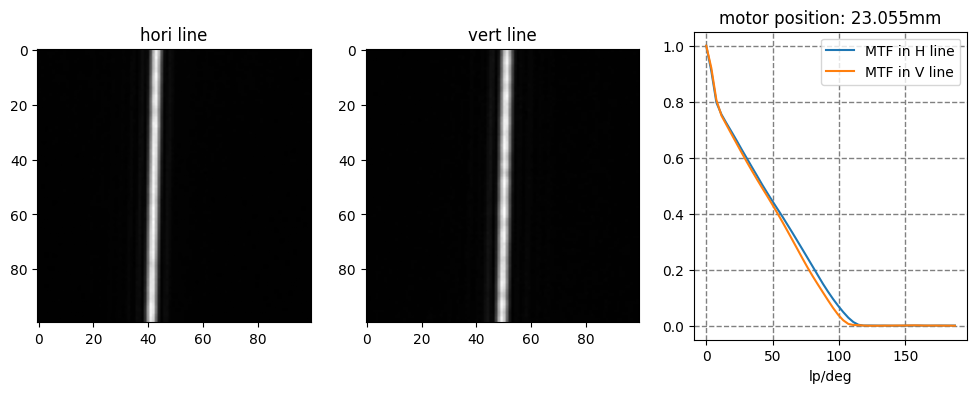

In [5]:
# Beam splitter Ref Stats Fine Fine
beamsplitter_scan_140ma_1000us = [{
    "title": f"{idx/1000:.3f}mm",
    "filename": f"xcube_data/0803/beamsplitter_scan_140ma_1000us/{idx/1000:.3f}.png",
    "roi_h_pos": (1203, 1056),
    "roi_v_pos": (1301, 960),
} for idx in range(22105, 23505, 5)]
print(len(beamsplitter_scan_140ma_1000us))
display_roi(beamsplitter_scan_140ma_1000us, 190, 100, 100)

In [43]:
# Beam splitter Ref Stats Fine Fine
t_focus_d_bs, t_focus_h_bs, t_focus_v_bs = do_thru_focus(beamsplitter_scan_140ma_1000us)   

In [45]:
print(np.array(t_focus_h_bs[:-30]).max())
print(np.array(t_focus_v_bs).max())

0.6491064444475896
0.6363139798183612


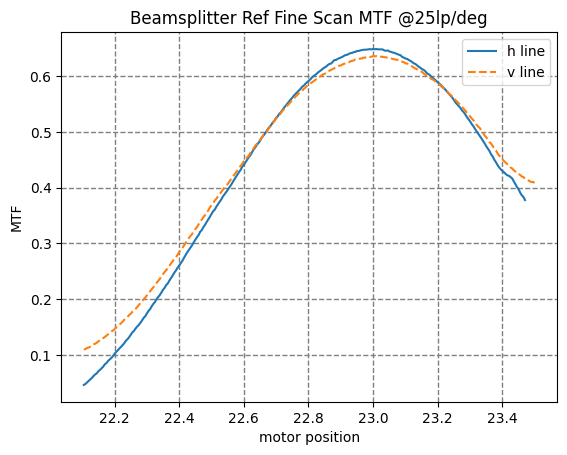

In [46]:
# plot thrufocus
plt.grid(color="gray", linestyle="--", linewidth=1)
plt.plot(t_focus_d_bs, t_focus_h_bs, label="h line", linestyle="-")
plt.plot(t_focus_d_bs, t_focus_v_bs, label="v line", linestyle="--")
plt.xlabel("motor position")
plt.ylabel("MTF")
plt.title("Beamsplitter Ref Fine Scan MTF @25lp/deg")
plt.legend()

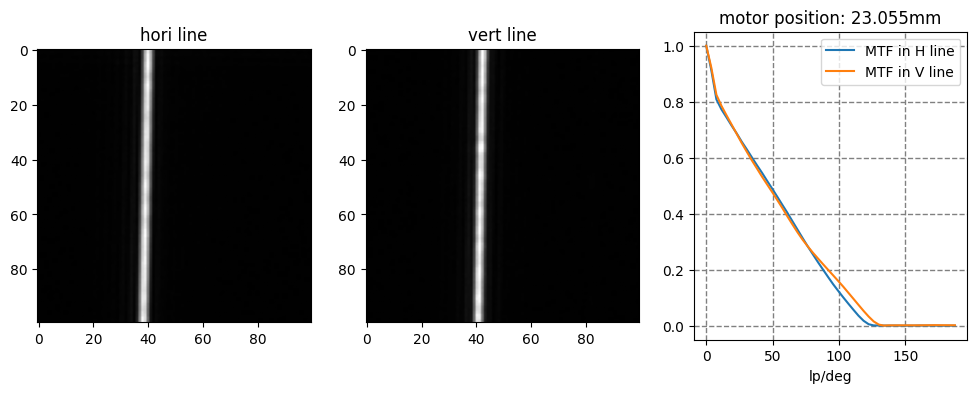

In [7]:
mirror_scan_140ma_400us = [{
    "title": f"{idx/1000:.3f}mm",
    "filename": f"xcube_data/0803/mirror_scan_140ma_400us/{idx/1000:.3f}.png",
    "roi_h_pos": (1190, 1065),
    "roi_v_pos": (1259, 910),
} for idx in range(22105, 23505, 5)]

display_roi(mirror_scan_140ma_400us, 190, 100, 100)

In [8]:
t_focus_d_mr, t_focus_h_mr, t_focus_v_mr = do_thru_focus(mirror_scan_140ma_400us)

In [42]:
print(np.array(t_focus_h_mr[:-30]).max()+0.04)
print(np.array(t_focus_v_mr).max())

0.7111267005032132
0.6990593945574125


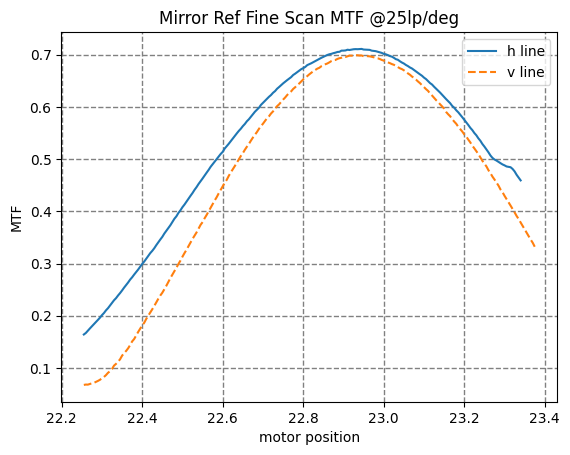

In [40]:
# plot thrufocus
plt.grid(color="gray", linestyle="--", linewidth=1)
plt.plot(t_focus_d_mr[30:-25], np.array(t_focus_h_mr[55:])+0.04, label="h line", linestyle="-")
plt.plot(t_focus_d_mr[30:-25], t_focus_v_mr[30:-25], label="v line", linestyle="--")
plt.xlabel("motor position")
plt.ylabel("MTF")
plt.title("Mirror Ref Fine Scan MTF @25lp/deg")
plt.legend()

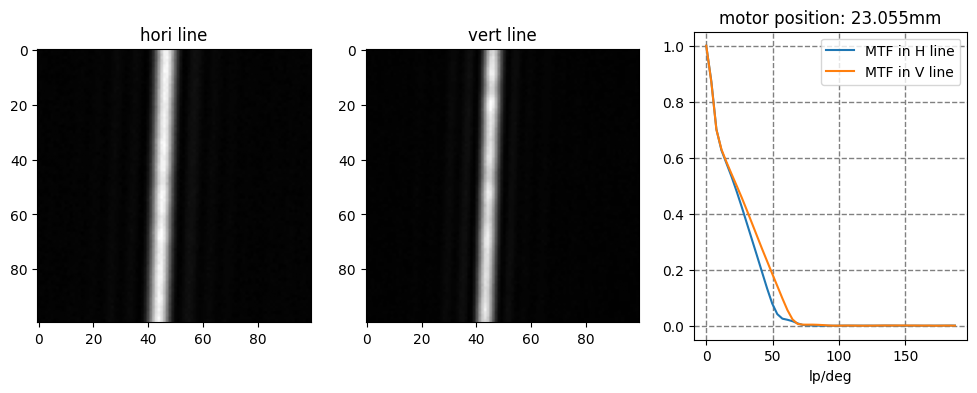

In [10]:
sample_a_140ma_1200us_1 = [{
    "title": f"{idx/1000:.3f}mm",
    "filename": f"xcube_data/0803/sample_a_140ma_1200us_1/{idx/1000:.3f}.png",
    "roi_h_pos": (1284, 915),
    "roi_v_pos": (1188, 1044),
} for idx in range(22105, 23500, 5)]

display_roi(sample_a_140ma_1200us_1, 190, 100, 100)

In [11]:
t_focus_d_a1, t_focus_h_a1, t_focus_v_a1 = do_thru_focus(sample_a_140ma_1200us_1)       

In [57]:
print(np.array(t_focus_h_a1[:-30]).max())
print(np.array(t_focus_v_a1).max())

0.4534022626370477
0.47899434435988575


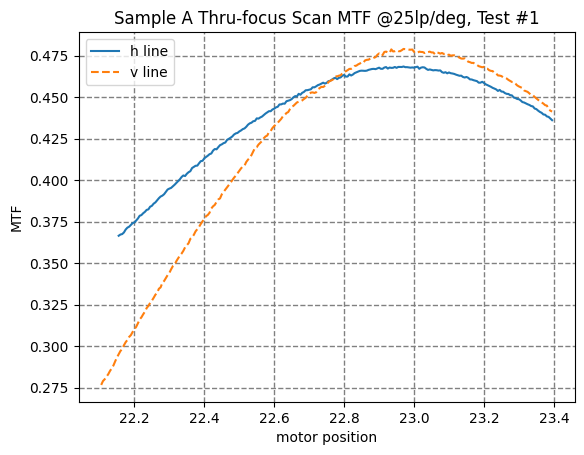

In [48]:
# plot thrufocus
plt.grid(color="gray", linestyle="--", linewidth=1)
plt.plot(t_focus_d_a1[10:-20], np.array(t_focus_h_a1[:-30])+0.015, label="h line", linestyle="-")
plt.plot(t_focus_d_a1[:-20], t_focus_v_a1[:-20], label="v line", linestyle="--")
plt.xlabel("motor position")
plt.ylabel("MTF")
plt.title("Sample A Thru-focus Scan MTF @25lp/deg, Test #1")
plt.legend()

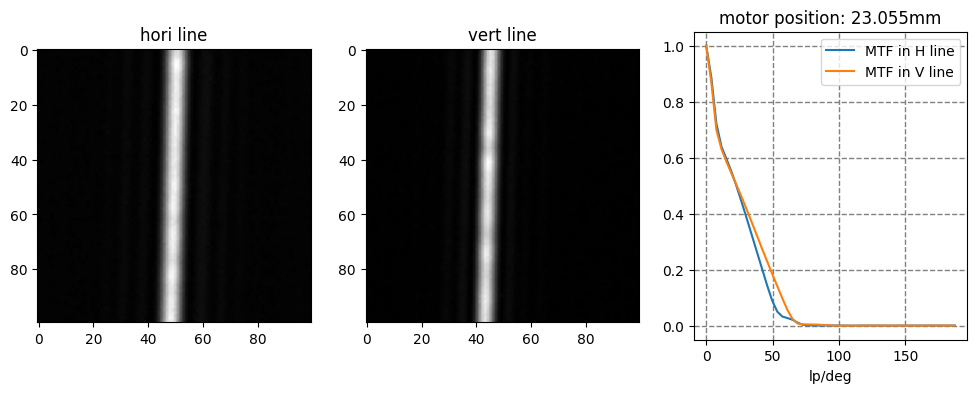

In [13]:
sample_a_140ma_1200us_2 = [{
    "title": f"{idx/1000:.3f}mm",
    "filename": f"xcube_data/0803/sample_a_140ma_1200us_2/{idx/1000:.3f}.png",
    "roi_h_pos": (1300, 1052),
    "roi_v_pos": (1191, 1164),
} for idx in range(22105, 23500, 5)]

display_roi(sample_a_140ma_1200us_2, 190, 100, 100)

In [14]:
t_focus_d_a2, t_focus_h_a2, t_focus_v_a2 = do_thru_focus(sample_a_140ma_1200us_2)

In [56]:
print(np.array(t_focus_h_a2[:-30]).max())
print(np.array(t_focus_v_a2).max())

0.4683429087978528
0.4808328359796001


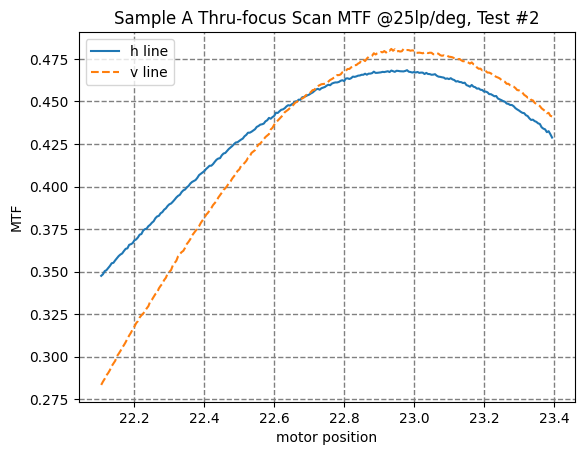

In [49]:
# plot thrufocus
plt.grid(color="gray", linestyle="--", linewidth=1)
plt.plot(t_focus_d_a2[:-20], t_focus_h_a2[:-20], label="h line", linestyle="-")
plt.plot(t_focus_d_a2[:-20], t_focus_v_a2[:-20], label="v line", linestyle="--")
plt.xlabel("motor position")
plt.ylabel("MTF")
plt.title("Sample A Thru-focus Scan MTF @25lp/deg, Test #2")
plt.legend()

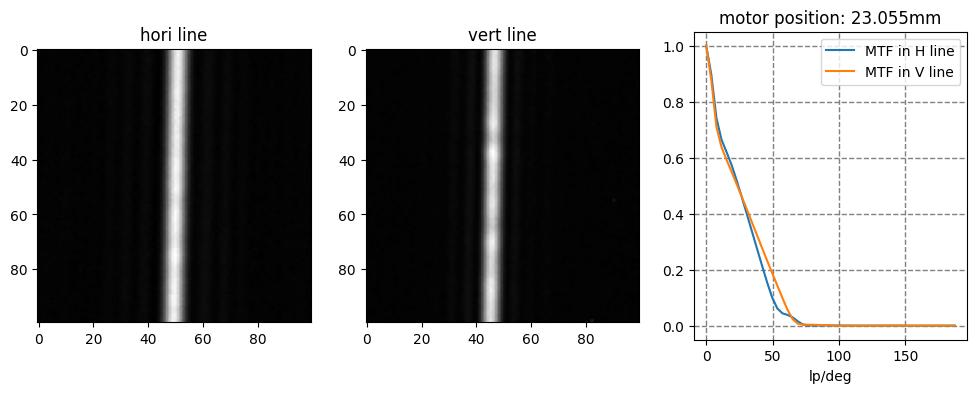

In [16]:
sample_a_140ma_1200us_3 = [{
    "title": f"{idx/1000:.3f}mm",
    "filename": f"xcube_data/0803/sample_a_140ma_1200us_3/{idx/1000:.3f}.png",
    "roi_h_pos": (1350, 1107),
    "roi_v_pos": (1247, 1224),
} for idx in range(22105, 23500, 5)]
display_roi(sample_a_140ma_1200us_3, 190, 100, 100)

In [17]:
t_focus_d_a3, t_focus_h_a3, t_focus_v_a3 = do_thru_focus(sample_a_140ma_1200us_3)   

In [54]:
print(np.array(t_focus_h_a3[:-30]).max()-0.02)
print(np.array(t_focus_v_a3).max())

0.4726065777199448
0.48286252658124146


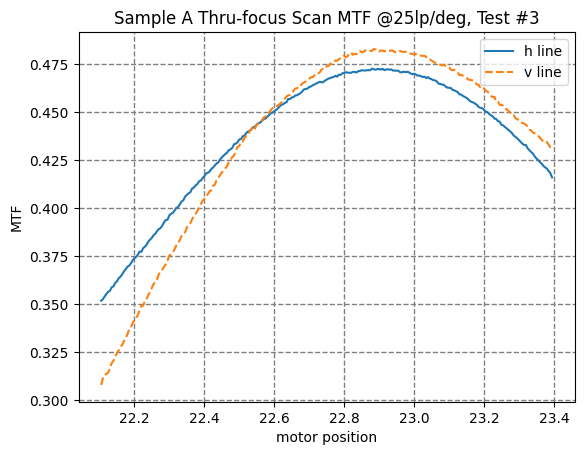

In [50]:
# plot thrufocus
plt.grid(color="gray", linestyle="--", linewidth=1)
plt.plot(t_focus_d_a3[:-20], np.array(t_focus_h_a3[:-20])-0.02, label="h line", linestyle="-")
plt.plot(t_focus_d_a3[:-20], t_focus_v_a3[20:], label="v line", linestyle="--")
plt.xlabel("motor position")
plt.ylabel("MTF")
plt.title("Sample A Thru-focus Scan MTF @25lp/deg, Test #3")
plt.legend()

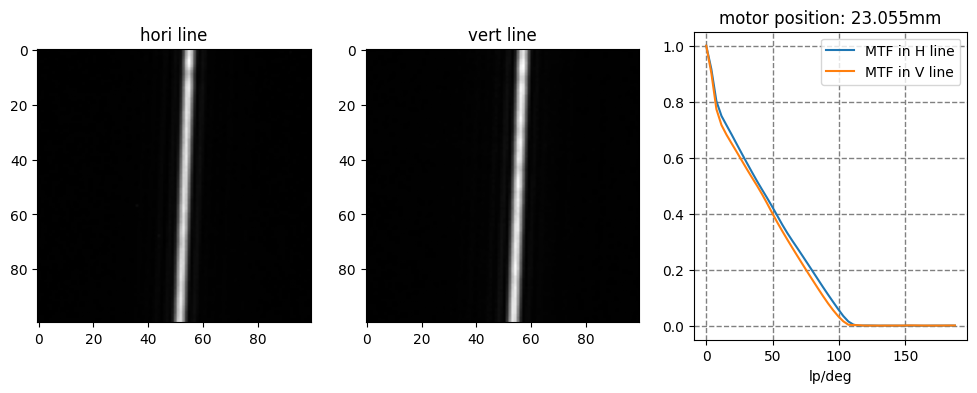

In [19]:
sample_x_140ma_550us_1 = [{
    "title": f"{idx/1000:.3f}mm",
    "filename": f"xcube_data/0803/sample_x_140ma_550us_1/{idx/1000:.3f}.png",
    "roi_h_pos": (1428, 907),
    "roi_v_pos": (1297, 1047),
} for idx in range(22105, 23500, 5)]

display_roi(sample_x_140ma_550us_1, 190, 100, 100)

In [20]:
t_focus_d_x1, t_focus_h_x1, t_focus_v_x1 = do_thru_focus(sample_x_140ma_550us_1)   

In [64]:
print(np.array(t_focus_h_x1[:-18]).max())
print(np.array(t_focus_v_x1[:-18]).max())

0.648478858013287
0.6046625624227128


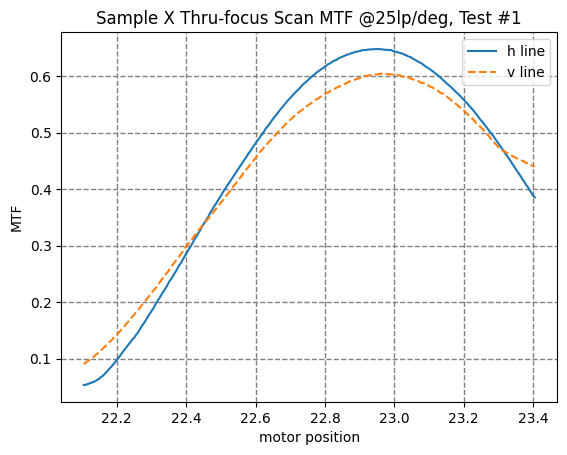

In [61]:
# plot thrufocus
plt.grid(color="gray", linestyle="--", linewidth=1)
plt.plot(t_focus_d_x1[:-18], t_focus_h_x1[:-18], label="h line", linestyle="-")
plt.plot(t_focus_d_x1[:-18], t_focus_v_x1[18:], label="v line", linestyle="--")
plt.xlabel("motor position")
plt.ylabel("MTF")
plt.title("Sample X Thru-focus Scan MTF @25lp/deg, Test #1")
plt.legend()

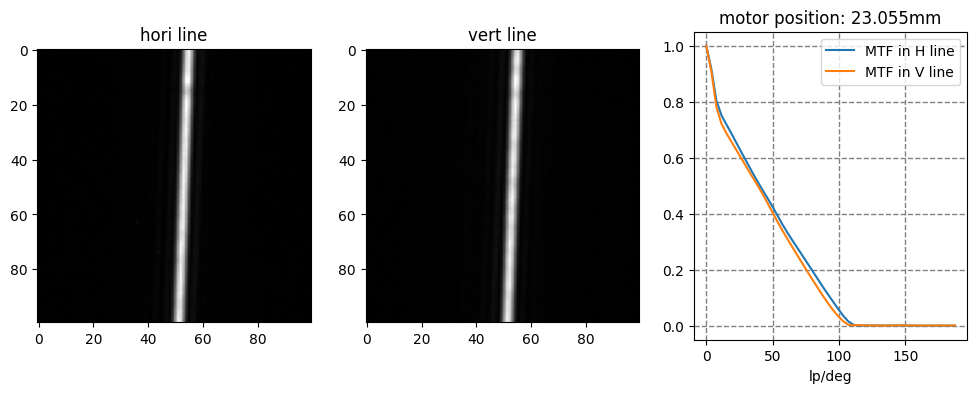

In [22]:
sample_x_140ma_550us_2 = [{
    "title": f"{idx/1000:.3f}mm",
    "filename": f"xcube_data/0803/sample_x_140ma_550us_2/{idx/1000:.3f}.png",
    "roi_h_pos": (1434, 907),
    "roi_v_pos": (1299, 1041),
} for idx in range(22105, 23500, 5)]

display_roi(sample_x_140ma_550us_2, 190, 100, 100)

In [23]:
t_focus_d_x2, t_focus_h_x2, t_focus_v_x2 = do_thru_focus(sample_x_140ma_550us_2)   

In [65]:
print(np.array(t_focus_h_x2[:-18]).max())
print(np.array(t_focus_v_x2[:-18]).max())

0.6498577502946888
0.6103136384816893


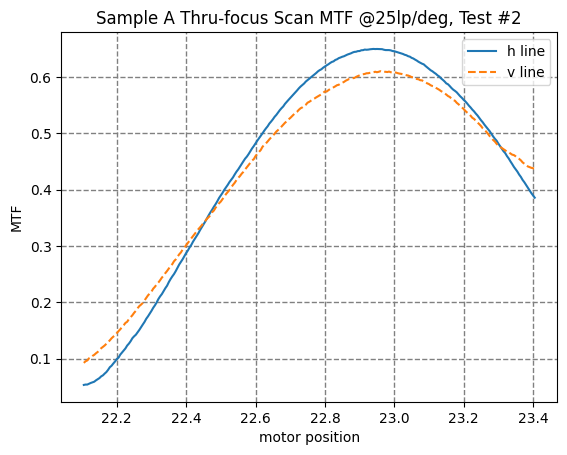

In [62]:
# plot thrufocus
plt.grid(color="gray", linestyle="--", linewidth=1)
plt.plot(t_focus_d_x2[:-18], t_focus_h_x2[:-18], label="h line", linestyle="-")
plt.plot(t_focus_d_x2[:-18], t_focus_v_x2[18:], label="v line", linestyle="--")
plt.xlabel("motor position")
plt.ylabel("MTF")
plt.title("Sample A Thru-focus Scan MTF @25lp/deg, Test #2")
plt.legend()

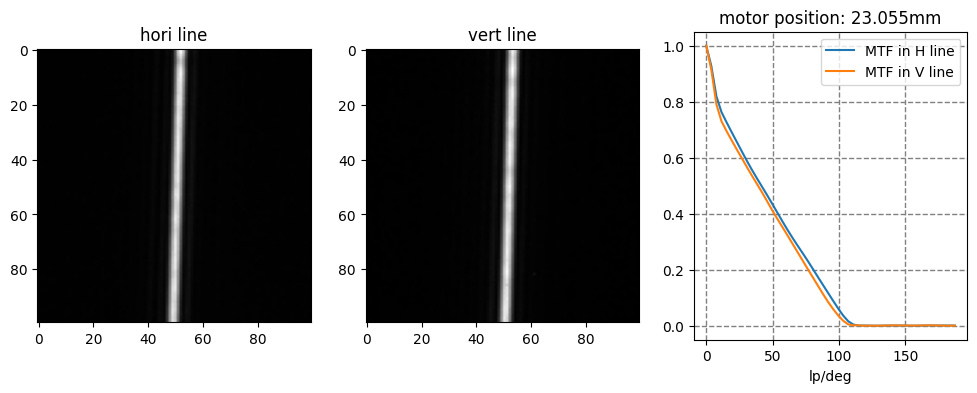

In [25]:
sample_x_140ma_550us_3 = [{
    "title": f"{idx/1000:.3f}mm",
    "filename": f"xcube_data/0803/sample_x_140ma_550us_3/{idx/1000:.3f}.png",
    "roi_h_pos": (1398, 1060),
    "roi_v_pos": (1276, 1197),
} for idx in range(22105, 23500, 5)]

display_roi(sample_x_140ma_550us_3, 190, 100, 100)

In [26]:
t_focus_d_x3, t_focus_h_x3, t_focus_v_x3 = do_thru_focus(sample_x_140ma_550us_3)    

In [66]:
print(np.array(t_focus_h_x3[:-18]).max())
print(np.array(t_focus_v_x3[:-18]).max())

0.6549481839567745
0.6132861380310027


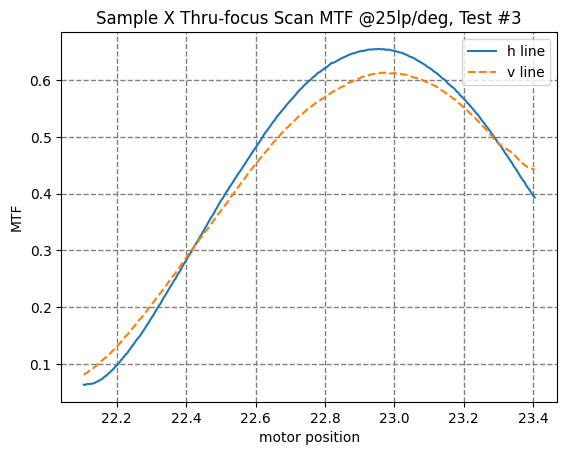

In [63]:
# plot thrufocus
plt.grid(color="gray", linestyle="--", linewidth=1)
plt.plot(t_focus_d_x3[:-18], t_focus_h_x3[:-18], label="h line", linestyle="-")
plt.plot(t_focus_d_x3[:-18], np.array(t_focus_v_x3[18:]), label="v line", linestyle="--")
plt.xlabel("motor position")
plt.ylabel("MTF")
plt.title("Sample X Thru-focus Scan MTF @25lp/deg, Test #3")
plt.legend()

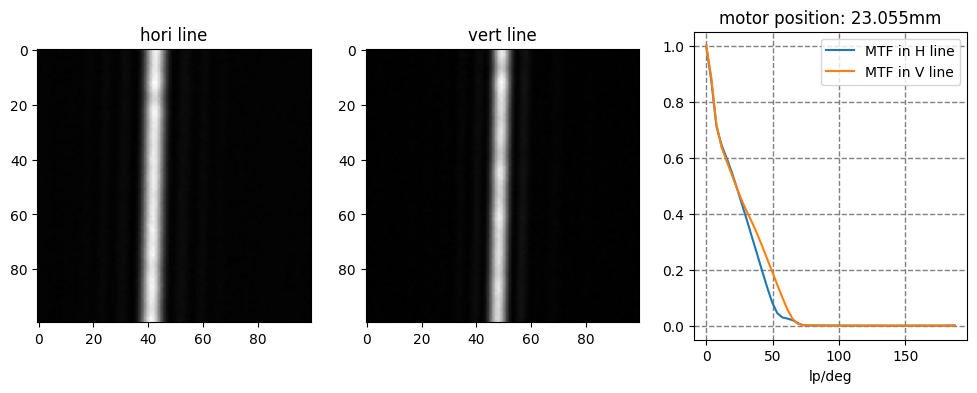

In [28]:
sample_s2_140ma_1200us_1 = [{
    "title": f"{idx/1000:.3f}mm",
    "filename": f"xcube_data/0803/sample_s2_140ma_1200us_1/{idx/1000:.3f}.png",
    "roi_h_pos": (1320, 1111),
    "roi_v_pos": (1190, 1245),
} for idx in range(22105, 23500, 5)]

display_roi(sample_s2_140ma_1200us_1, 190, 100, 100)

In [29]:
t_focus_d_s21, t_focus_h_s21, t_focus_v_s21 = do_thru_focus(sample_s2_140ma_1200us_1)    

In [79]:
print(np.array(t_focus_h_s21[:-18]).max()+0.015)
print(np.array(t_focus_v_s21[:-18]).max()-0.015)

0.4819512046044358
0.4661805288003074


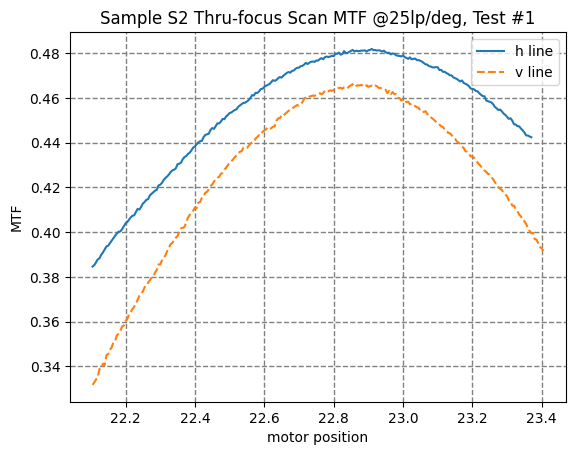

In [75]:
# plot thrufocus
plt.grid(color="gray", linestyle="--", linewidth=1)
plt.plot(t_focus_d_s21[:-25], np.array(t_focus_h_s21[5:-20])+0.015, label="h line", linestyle="-")
plt.plot(t_focus_d_s21[:-18], np.array(t_focus_v_s21[:-18])-0.015, label="v line", linestyle="--")
plt.xlabel("motor position")
plt.ylabel("MTF")
plt.title("Sample S2 Thru-focus Scan MTF @25lp/deg, Test #1")
plt.legend()

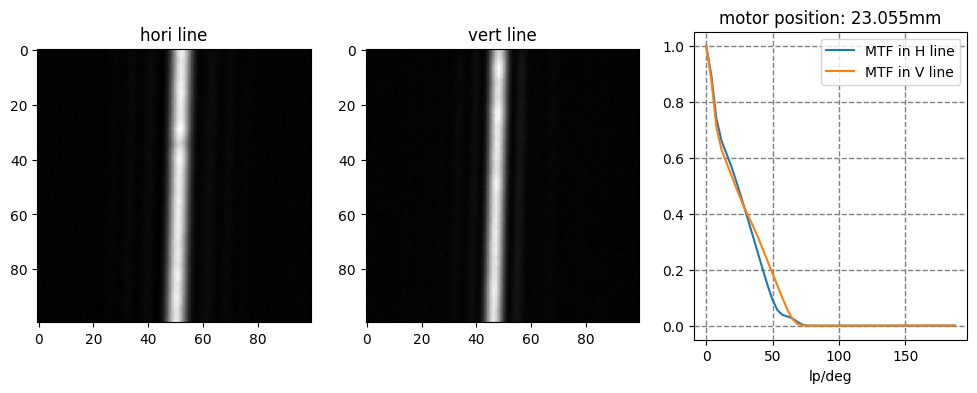

In [31]:
sample_s2_140ma_1200us_2 = [{
    "title": f"{idx/1000:.3f}mm",
    "filename": f"xcube_data/0803/sample_s2_140ma_1200us_2/{idx/1000:.3f}.png",
    "roi_h_pos": (1360, 999),
    "roi_v_pos": (1213, 1179),
} for idx in range(22105, 23500, 5)]

display_roi(sample_s2_140ma_1200us_2, 190, 100, 100)

In [32]:
# Sample S2 #2
t_focus_d_s22, t_focus_h_s22, t_focus_v_s22 = do_thru_focus(sample_s2_140ma_1200us_2)

In [77]:
print(np.array(t_focus_h_s22[:-18]).max())
print(np.array(t_focus_v_s22[:-18]).max())

0.4834986189313481
0.47393055711659143


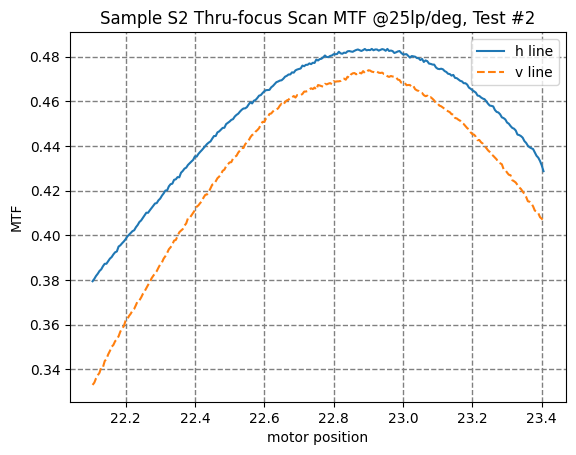

In [73]:
# plot thrufocus
plt.grid(color="gray", linestyle="--", linewidth=1)
plt.plot(t_focus_d_s22[:-18], t_focus_h_s22[:-18], label="h line", linestyle="-")
plt.plot(t_focus_d_s22[:-18], t_focus_v_s22[:-18], label="v line", linestyle="--")
plt.xlabel("motor position")
plt.ylabel("MTF")
plt.title("Sample S2 Thru-focus Scan MTF @25lp/deg, Test #2")
plt.legend()

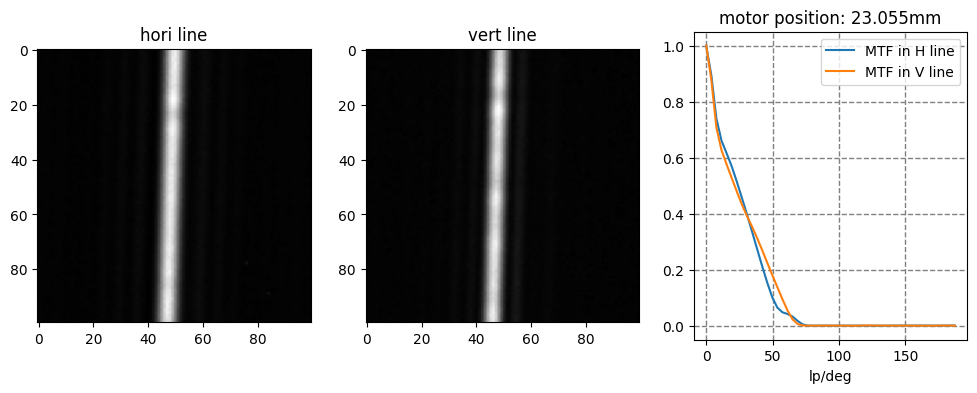

In [34]:
sample_s2_140ma_1200us_3 = [{
    "title": f"{idx/1000:.3f}mm",
    "filename": f"xcube_data/0803/sample_s2_140ma_1200us_3/{idx/1000:.3f}.png",
    "roi_h_pos": (1449, 867),
    "roi_v_pos": (1313, 996),
} for idx in range(22105, 23500, 5)]

display_roi(sample_s2_140ma_1200us_3, 190, 100, 100)

In [35]:
# Sample S2 #3
t_focus_d_s23, t_focus_h_s23, t_focus_v_s23 = do_thru_focus(sample_s2_140ma_1200us_3)

In [76]:
print(np.array(t_focus_h_s23[:-18]).max())
print(np.array(t_focus_v_s23[:-18]).max())

0.4895761114672221
0.4660428021345643


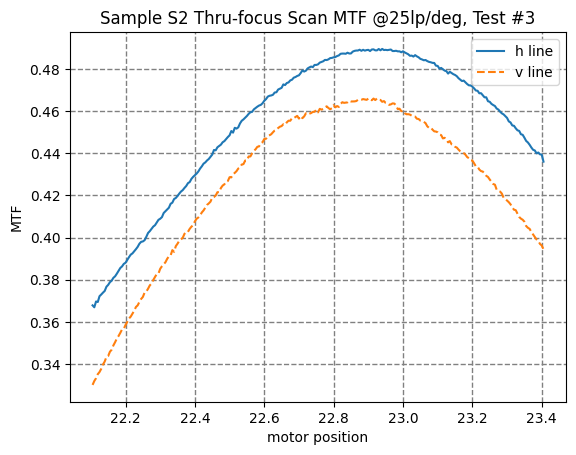

In [74]:
# plot thrufocus
plt.grid(color="gray", linestyle="--", linewidth=1)
plt.plot(t_focus_d_s23[:-18], t_focus_h_s23[:-18], label="h line", linestyle="-")
plt.plot(t_focus_d_s23[:-18], t_focus_v_s23[:-18], label="v line", linestyle="--")
plt.xlabel("motor position")
plt.ylabel("MTF")
plt.title("Sample S2 Thru-focus Scan MTF @25lp/deg, Test #3")
plt.legend()